In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

In [10]:
data = pd.read_csv("data/rubusd-intraday-1min.csv")
data = data[["Time", "Change"]]
data["Time"] = pd.to_datetime(data["Time"])
data = data.loc[::-1].reset_index(drop=True)

In [11]:
def build_markov_chain(series: list[float], decimals: int) -> dict[float: list[float]]:
    chain = dict()
    for i in range(len(series) - 1):
        if round(series[i], decimals) not in chain.keys():
            chain[round(series[i], decimals)] = [round(series[i+1], decimals)]
        else:
            chain[round(series[i], decimals)].append(round(series[i+1], decimals))
    return chain

def build_markov_grid(series: list[float], decimals: int, width: float, elim_zero: bool = True) -> tuple[pd.DataFrame, list[float]]:
    series = [round(i, decimals) for i in series]
    num = int((((width + width)) * 10**decimals) + 1)
    X = [round(i, decimals) for i in np.linspace(-width, width, num).tolist()]
    grid = pd.DataFrame(np.zeros((len(X), len(X))))
    grid.columns, grid.index = X, X
    dropped = list()
    for i, v in enumerate(series[:-1]):
        if (abs(v) < width) and abs(series[i+1] < width):
            try:
                grid.at[v, series[i+1]] += 1
            except:
                dropped.append(v)
    if elim_zero:
        grid.at[0,0] = 0
    return grid, dropped

In [35]:
def plot_grid_timebound(data: pd.DataFrame, start: datetime, end: datetime, decimals: int = 6, width: float = 0.00002, title: str = None, save: str=None, minimal: bool = False):
    sample = data[(data["Time"] > start) & (data["Time"] < end)]["Change"].astype(float).dropna().tolist()
    mg, _ = build_markov_grid(series=sample, decimals=decimals, width=width)
    if minimal:
        plt.figure(figsize=(6,6))
        sns.heatmap(mg, cbar=False)
        plt.yticks([])
        plt.xticks([])
    else:
        plt.figure(figsize=(8,7))
        sns.heatmap(mg)
    plt.title(title, y=0.9, c="white")
    if save is not None:
        plt.savefig(save, transparent=True)

In [36]:
months = list(pd.to_datetime(pd.date_range("2021-12-31", "2022-12-31", freq="M")))

/var/folders/n3/l052vzts1dq29hfth7kzjpx80000gn/T/ipykernel_52893/1718043390.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,6))


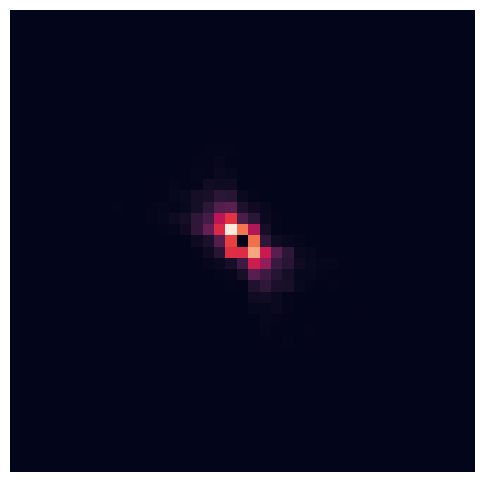

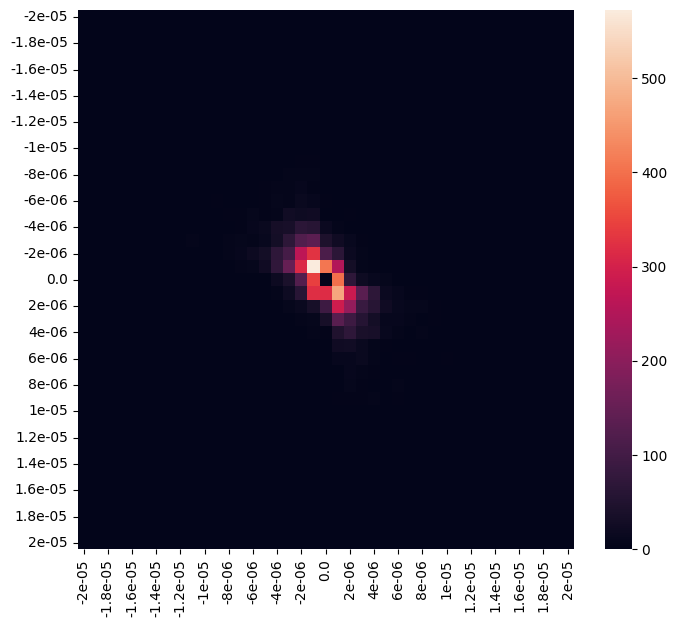

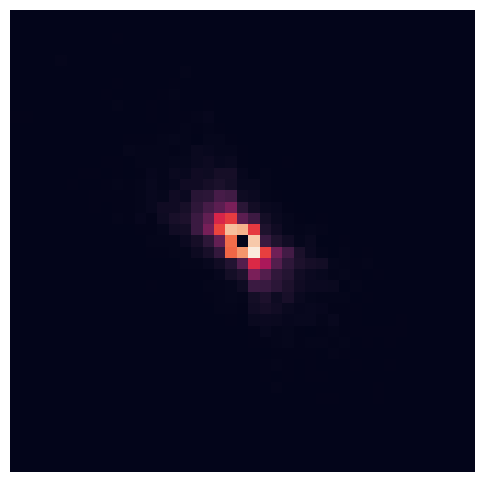

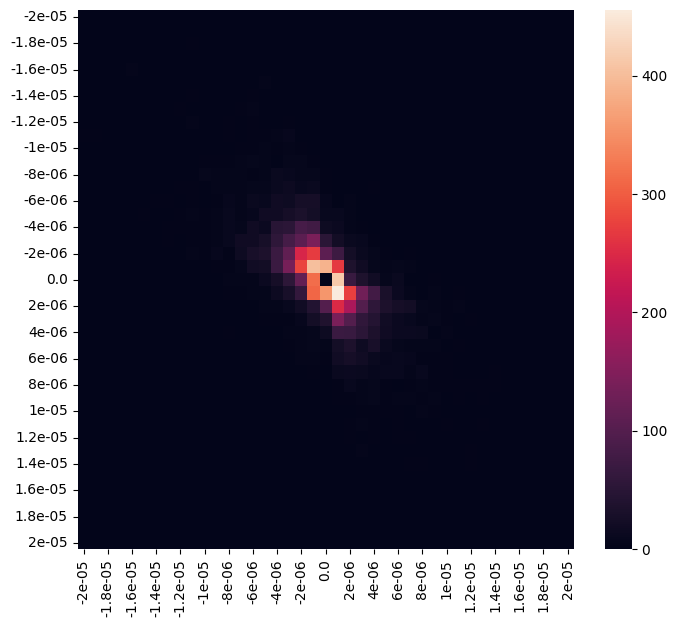

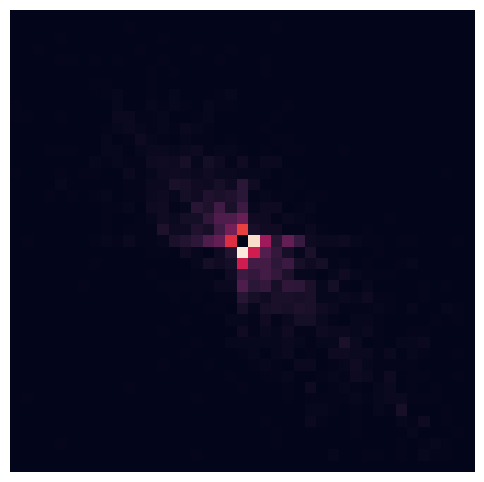

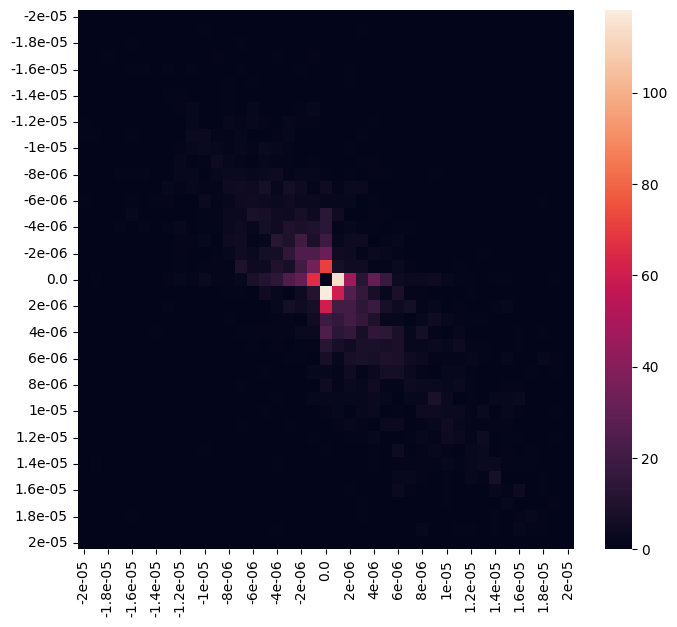

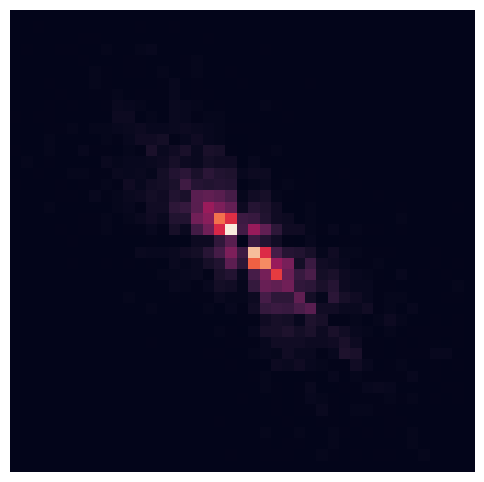

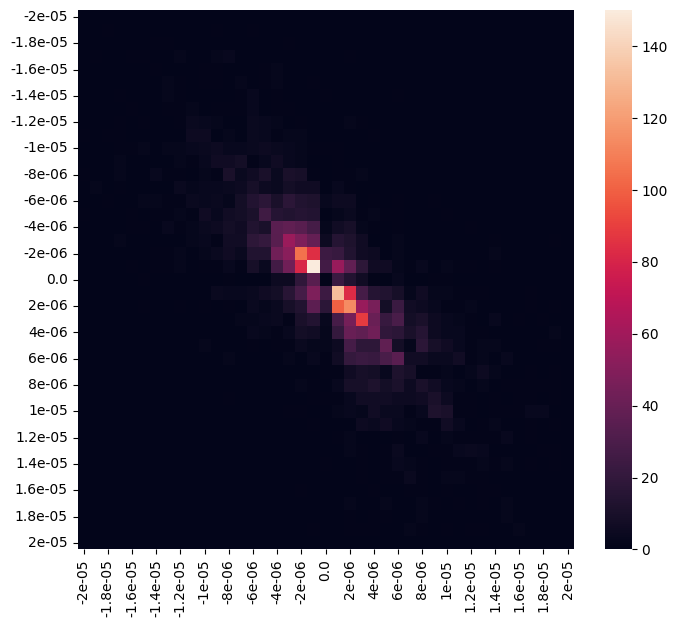

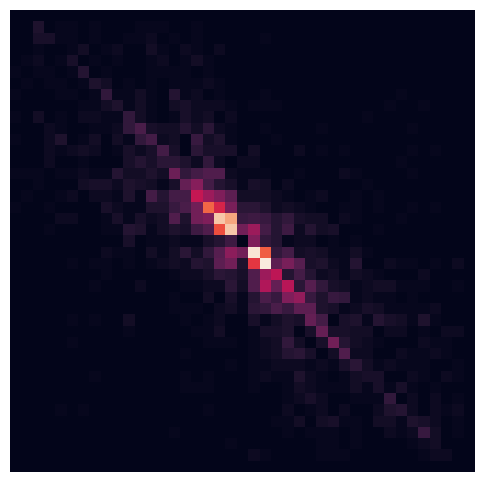

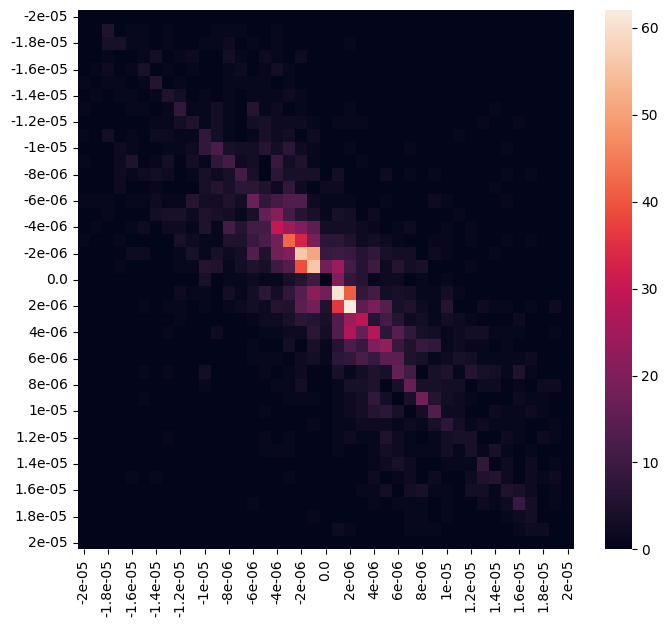

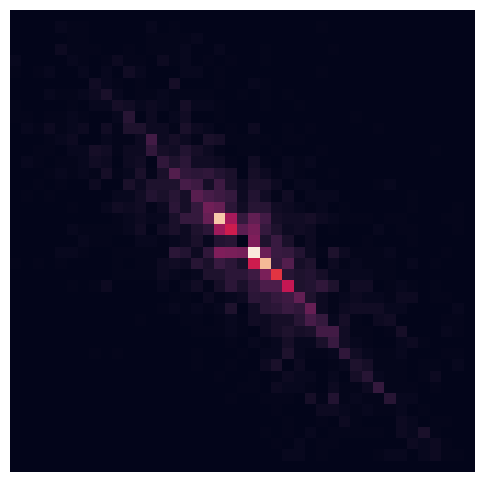

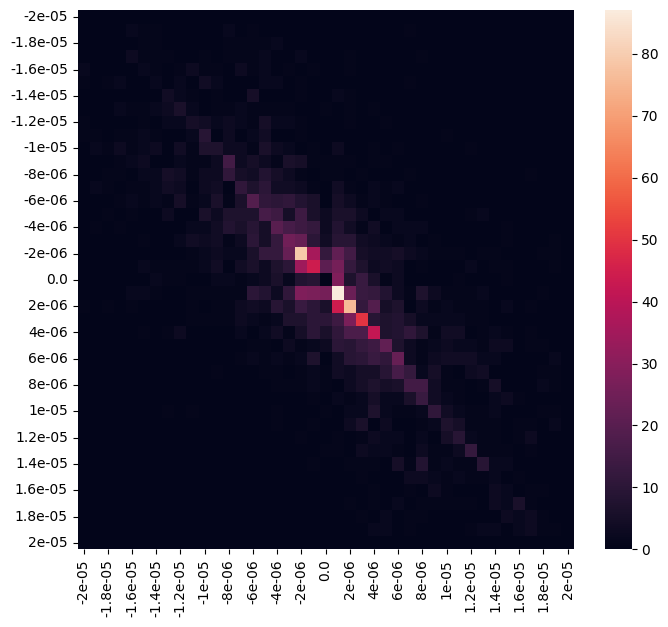

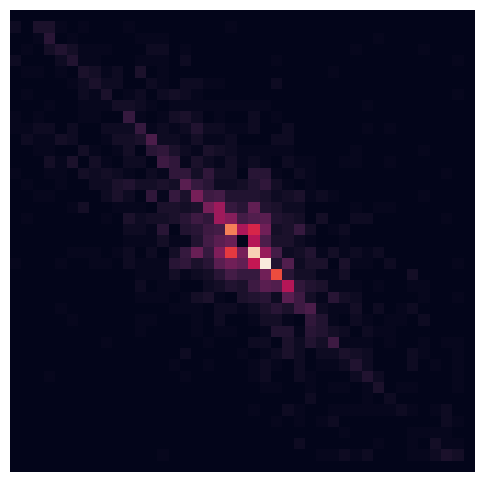

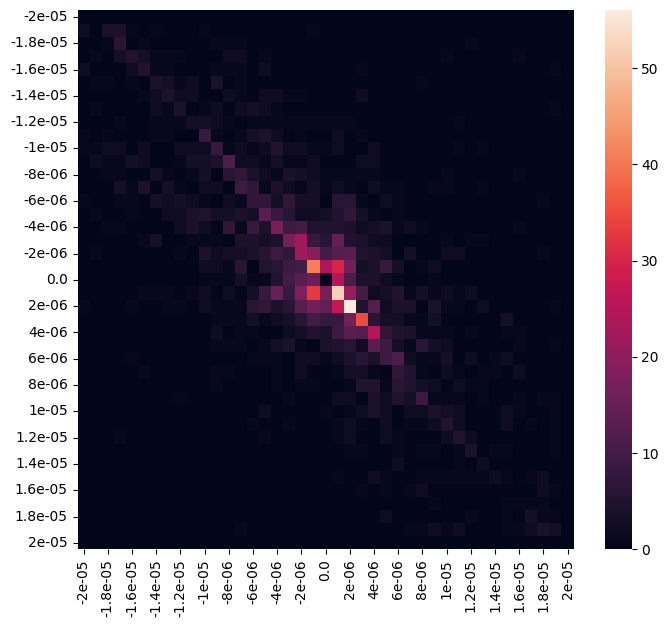

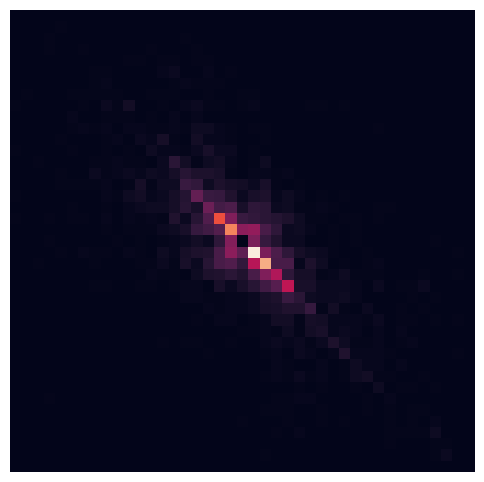

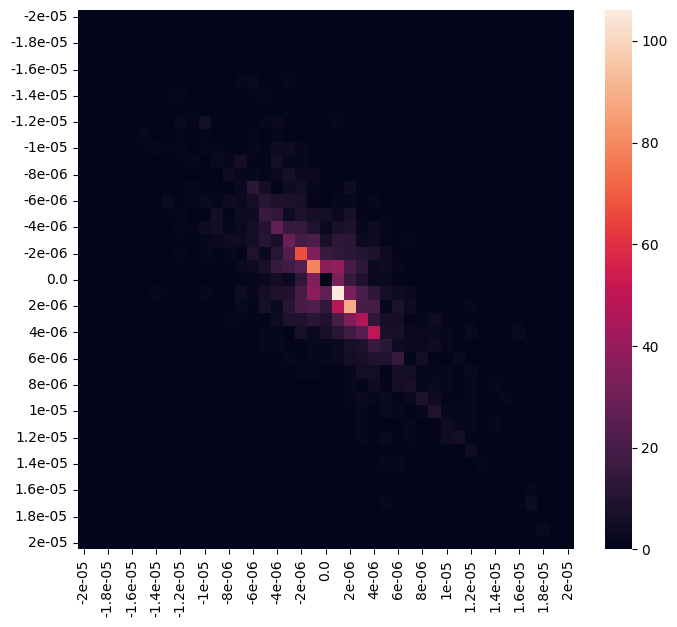

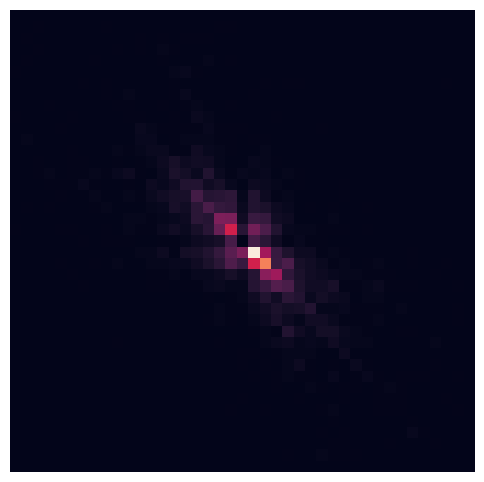

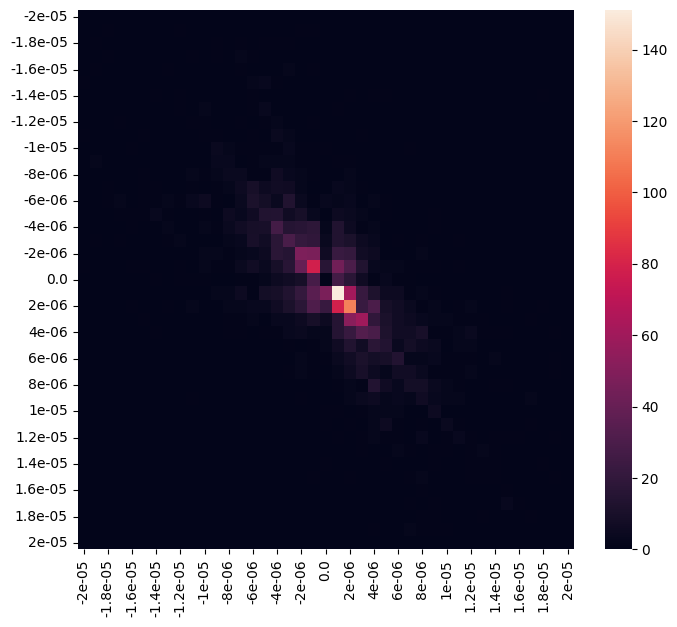

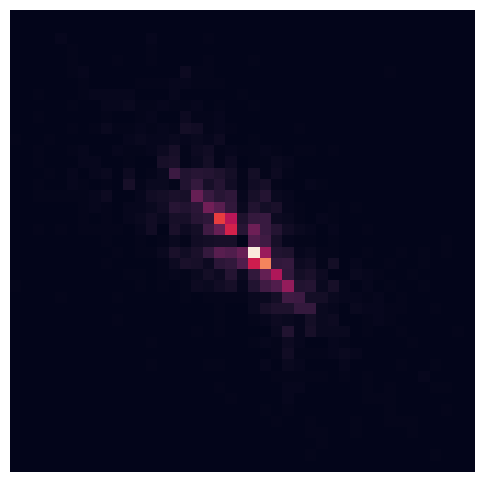

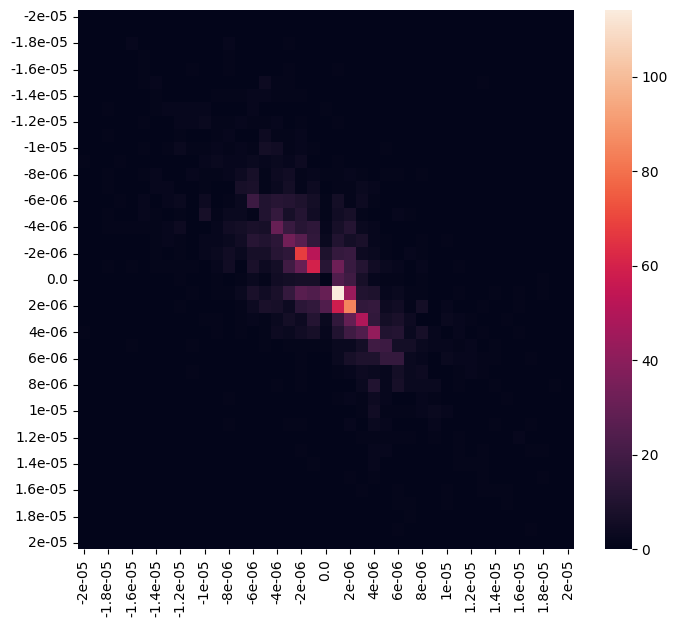

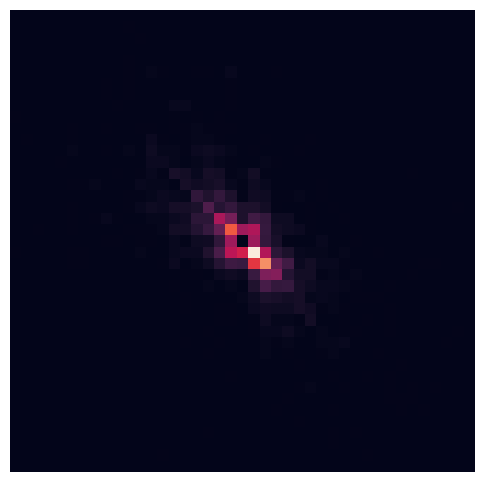

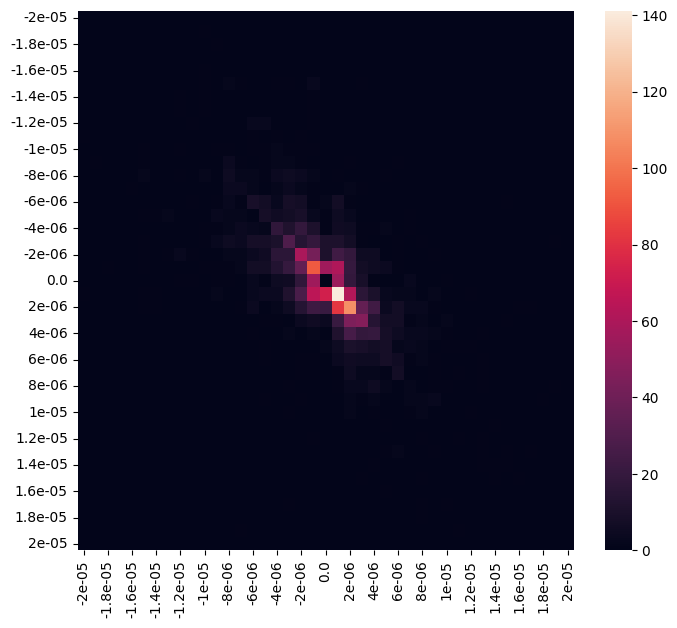

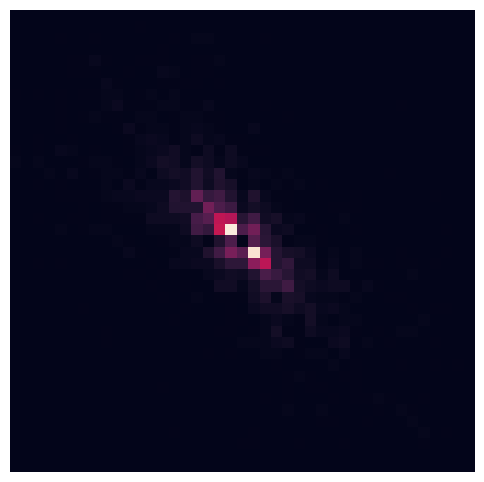

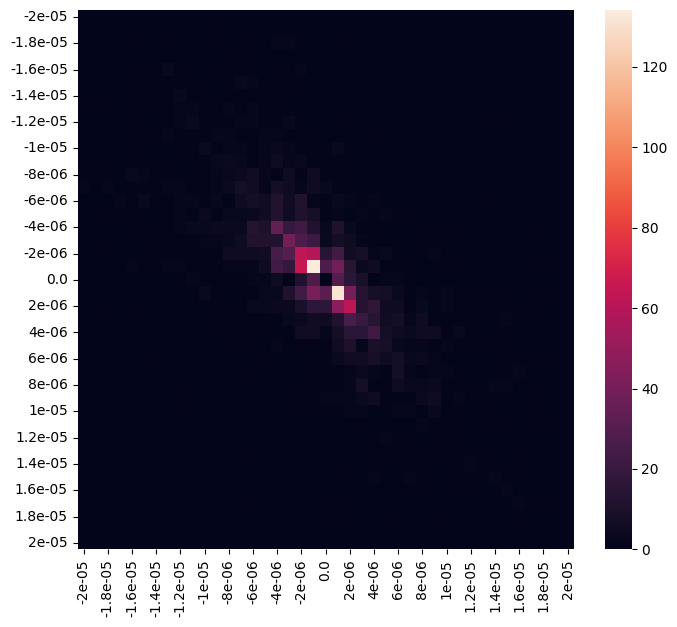

In [38]:
for i, v in enumerate(months[:-1]):
    m = str(months[i+1])[:7]
    plot_grid_timebound(data=data, start=v, end=months[i+1], save=f"asset/minimal/{m}.png", minimal=True)
    plot_grid_timebound(data=data, start=v, end=months[i+1], save=f"asset/full/{m}.png", minimal=False)